In [2]:
# Manufacturing Consent Analysis and Data Description

## Data Description

In [3]:
#packages used
import urllib2 as ul
from bs4 import BeautifulSoup as bs
import re
import time
import random

#A function that performs a google search and collects links from that page.  Please use sparingly, if at all.
#name is the candidate name, qualify appends to that search some qualifier, start is where to begin the link page.
#returns an array of links and the number of hits for that search

def NewsQuery(name,site,start=0,qualify='+2016+presidential+election'):
    name=name.replace(' ','+')
    url='https://www.google.com/search?q=site:'+site+'.com+'+name+qualify
    url2='&start='+str(start)
    url=url+url2
    #agents = {'User-Agent':"Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1;SV1; .NET CLR 1.1.4322; .NET CLR 2.0.50727; .NET CLR 3.0.04506.30)"}
    agents = {'User-Agent':"Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11"}
    request = ul.Request(url, headers=agents)
    page = ul.urlopen(request).read()
    soup = bs(page,"html.parser") 
    links = []
    for link in soup.find_all('a'):
        try:
            tmp=link.get('href')
            #if tmp.find('http://www.'+site+'.com')>-1 and tmp.find('http://webcache.googleusercontent')==-1:
            if tmp.find('http://www.'+site+'.com')>-1 and tmp.find('http://webcache.googleusercontent')==-1:
                links.append(link.get('href'))
        except AttributeError:
            continue
    tmp=[]
    for i in links:
        #print i
        a=i.find('http://www.'+site)
        b=i.find('&')
        c=i.find('%')
        try:
            b=min([k for k in [b,c] if k>a])
        except ValueError:
            continue
        tmp.append(i[a:b])
    links=set(tmp)
    links=list(links)
    return links,HitNumber(page,start=start)

#takes as inputs a google search page and finds the number of searches; low budget approach
def HitNumber(page,start=0):
    if start==0:
        a=[m.start() for m in re.finditer('About', page)]
    else:
        a=[m.start() for m in re.finditer('about', page)]
    b=[m.start() for m in re.finditer('result', page)]
    #print a,b
    for i in a:
        for j in b:
            if j-i<20 and j>i:
                tmp = page[i+5:j]
                tmp=tmp.replace(' ','')
                tmp=tmp.replace(',','')
                return int(tmp)

#after links are found this function will grab the page and return it, writing to disk if asked.
def GrabPage(link,write=0):
    agents = {'User-Agent':"Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11"}
    request = ul.Request(link, headers=agents)
    page = ul.urlopen(request).read()
    if write==1:
        name=link.split('/')[-1]
        if len(name)==0:
            name=link.split('/')[-2]
            #return page
        print 'writing:', name
        f=open('./dat/'+name,'w')
        f.write(page)
    return page

In [4]:
#The Candidates and news sources were chosen

candidates = ['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Ted Cruz']
newssources = ['foxnews','bloomberg','cnn','nytimes','nypost','latimes','dailynews','abcnews.go','nbcnews','rt','ft','aljazeera','huffingtonpost','buzzfeed']#,''
links={}
nhits={}
for i in candidates:
    links[i]=[]
    nhits[i]=[]

#The first few links are collected as well as the number of hits
for i in newssources:
    print i
    for j in candidates:
        pages,hits=NewsQuery(j,i,qualify='')
        links[j]+=pages
        nhits[j]+=[hits]
        print '    ',j, hits

foxnews
     Hillary Clinton 156000
     Donald Trump 185000
     Bernie Sanders 39400
     Ted Cruz 84600
bloomberg
     Hillary Clinton 616000
     Donald Trump 591000
     Bernie Sanders 585000
     Ted Cruz 619000
cnn
     Hillary Clinton 121000
     Donald Trump 150000
     Bernie Sanders 60500
     Ted Cruz 46400
nytimes
     Hillary Clinton 326000
     Donald Trump 630000
     Bernie Sanders 439000
     Ted Cruz 204000
nypost
     Hillary Clinton 199000
     Donald Trump 154000
     Bernie Sanders 9940
     Ted Cruz 30100
latimes
     Hillary Clinton 21600
     Donald Trump 11700
     Bernie Sanders 5780
     Ted Cruz 5070
dailynews
     Hillary Clinton 1750
     Donald Trump 1320
     Bernie Sanders 1440
     Ted Cruz 1400
abcnews.go
     Hillary Clinton 149000
     Donald Trump 196000
     Bernie Sanders 161000
     Ted Cruz 96400
nbcnews
     Hillary Clinton 78200
     Donald Trump 62300
     Bernie Sanders 62600
     Ted Cruz 38500
rt
     Hillary Clinton 19700
     Donald T

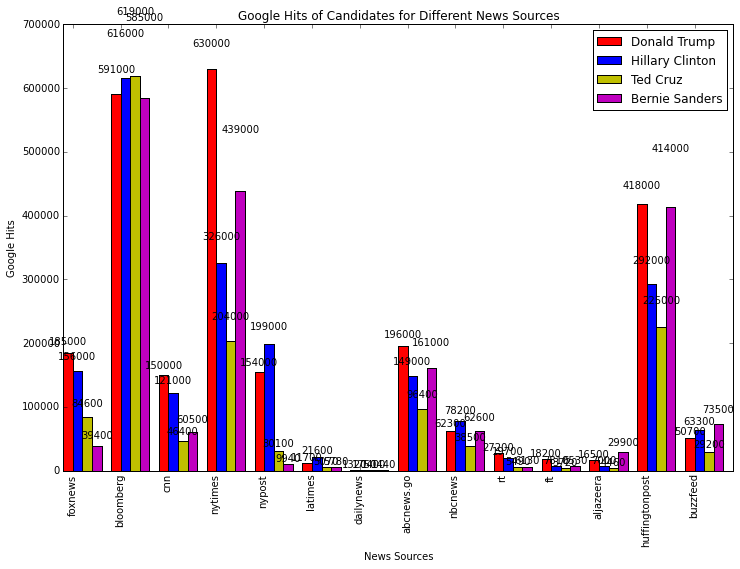

In [5]:
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline 

N = 14
DThits = nhits['Donald Trump']

ind = np.arange(N)  # the x locations for the groups
width = 0.2       # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(ind, DThits, width, color='r')

HChits = nhits['Hillary Clinton']
rects2 = ax.bar(ind + width, HChits, width, color='b')

TChits = nhits['Ted Cruz']
rects3 = ax.bar(ind + 2*width, TChits, width, color='y')

BShits = nhits['Bernie Sanders']
rects4 = ax.bar(ind + 3*width, BShits, width, color='m')

# add some text for labels, title and axes ticks
ax.set_ylabel('Google Hits')
ax.set_title('Google Hits of Candidates for Different News Sources')
ax.set_xticks(ind + width)
ax.set_xlabel('News Sources')
ax.set_xticklabels(newssources, rotation='vertical')

ax.legend((rects1[0], rects2[0],rects3[0],rects4[0]), ('Donald Trump', 'Hillary Clinton','Ted Cruz','Bernie Sanders'))


def autolabel(rects,mheight=1.05):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., mheight*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1,mheight=1.05)
autolabel(rects2,mheight=1.10)
autolabel(rects3,mheight=1.15)
autolabel(rects4,mheight=1.20)
plt.show()

In [11]:
#next we look over the whole corpus and count how many times the names are mentioned

#find_all function taken from http://stackoverflow.com/questions/4664850/find-all-occurrences-of-a-substring-in-python
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub)
        
labels = ['Clinton', 'Trump', 'Sanders', 'Cruz']
cnts = [0 for i in labels]

g=open('datlist')
for line in g:
    line=line.replace('\n','')
    h=open('./dat/'+line)
    page=h.read()
    for i,j in enumerate(labels):
        cnt = list(find_all(page, j))
        cnts[i]+=len(cnt)

scnts = float(sum(cnts))
print cnts,scnts
ncnts = [i*100/scnts for i in cnts]
print ncnts

[99844, 140658, 75921, 64617] 381040.0
[26.203023304639935, 36.914234726013014, 19.924679823640563, 16.95806214570649]


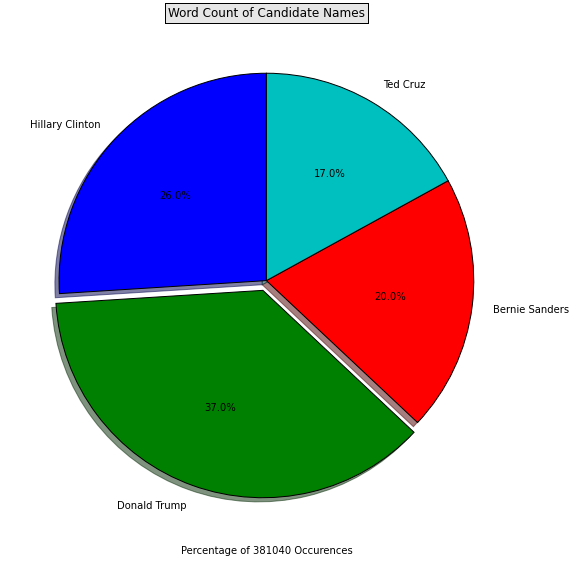

In [14]:
from pylab import *

# make a square figure and axes
figure(1, figsize=(9,9))
ax = axes([0.1, 0.1, 0.8, 0.8])
ax.set_xlabel('Percentage of 381040 Occurences')

# The slices will be ordered and plotted counter-clockwise.
labels = ['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Ted Cruz']
fracs = [26, 37, 20, 17]
explode=(0, 0.05, 0, 0)

pie(fracs, explode=explode, labels=labels,
                autopct='%1.1f%%', shadow=True, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

title('Word Count of Candidate Names', bbox={'facecolor':'0.9', 'pad':7})

show()